In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as tfs

import matplotlib.pyplot as plt
import numpy as np
import random
import json
import time

import math
from models import LogisticRegressor, Convolutional
from run_pipeline import main

In [2]:
N_EPOCHS = 250
F_RANGE = (2, 40)
W_RANGE = (-3, 2)
W_CENTER = 10

In [3]:
n_features = abs(F_RANGE[1] - F_RANGE[0])
win_dim = abs(W_RANGE[1] - W_RANGE[0])

In [4]:
train_data = []
test_data = []
n_videos = 0

def construct_tensors(matrix, state):
    w_range = (W_RANGE[0] + W_CENTER, W_CENTER + W_RANGE[1])
    matrix = np.abs(np.array(matrix))

    # Prepare vector & matrix for regressor & convolutional
    r_vector = matrix[W_CENTER, F_RANGE[0]:F_RANGE[1]].flatten()
    c_matrix = matrix[w_range[0]:w_range[1], F_RANGE[0]:F_RANGE[1]]

    x0 = torch.FloatTensor(r_vector)
    x1 = torch.FloatTensor([c_matrix])
    y = torch.tensor(state)
    return (x0, x1, y)

with open('data/mfccs_40_4096_1024.json') as f:
    json_data = json.load(f)
    n_videos = len(json_data)

    # Loop over all videos in dataset
    for i, video in enumerate(json_data):
        video_data = json_data[video]

        for data in video_data:
            matrix, dtime, state = data['m'], data['t'], data['s']
            if matrix != []:
                if i < 9:
                    train_data.append(construct_tensors(matrix, state))
                else:
                    test_data.append(construct_tensors(matrix, state))

print(f'Extracted {len(train_data)} train points and {len(test_data)} test points from {n_videos} videos')

Extracted 2456 train points and 322 test points from 10 videos


In [5]:
print(train_data[0][0].shape)
print(train_data[0][1].shape)

torch.Size([38])
torch.Size([1, 5, 38])


In [6]:
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=64,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size=64,
                                           shuffle=True)

In [7]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(f'Device: {device}')

Device: cpu


In [8]:
regressor, conv = LogisticRegressor(n_features, 1, 2).to(device), Convolutional(n_features, win_dim, 2).to(device)
print(f'n_params={sum(p.numel() for p in regressor.parameters())}')
print(f'n_params={sum(p.numel() for p in conv.parameters())}')

n_params=1662
n_params=12019


In [9]:
optis = [optim.SGD(regressor.parameters(), lr=0.001), optim.SGD(conv.parameters(), lr=0.001)]
crits = [nn.CrossEntropyLoss(), nn.CrossEntropyLoss()]

In [10]:
def accuracy(model, data, inds):
    x, y = inds
    correct, total = 0, 0
    for xxy in data:
        y_hat = model(xxy[x].to(device))
        _, predicted = torch.max(y_hat.data, 1)
        
        total += xxy[y].size(0)
        correct += (predicted.cpu() == xxy[y]).sum()

    return 100 * int(correct) / total

def confusion(model, data, inds):
    x, y = inds
    matrix = np.array([[0, 0], [0, 0]])
    exampl = [[[], []], [], []]
    for xxy in data:
        y_hat = model(xxy[x].to(device))
        _, predicted = torch.max(y_hat.data, 1)
        predicted = predicted.cpu()

        matrix[0, 0] += torch.sum((xxy[y] == 1) & (predicted == 1))
        matrix[0, 1] += torch.sum((xxy[y] == 0) & (predicted == 1))
        matrix[1, 0] += torch.sum((xxy[y] == 1) & (predicted == 0))
        matrix[1, 1] += torch.sum((xxy[y] == 0) & (predicted == 0))

    return matrix

def recall(model, data, inds):
    x, y = inds
    tp, fn = 0, 0
    for xxy in data:
        y_hat = model(xxy[x].to(device))
        _, predicted = torch.max(y_hat.data, 1)

        tp += torch.sum((xxy[y] == 1) & (predicted.cpu() == 1))
        fn += torch.sum((xxy[y] == 1) & (predicted.cpu() == 0))
    return int(tp) / (int(tp) + int(fn))


In [11]:
accuracy_histories = [[], []]
n_iters = 0
start = time.time()

for epoch in range(1, N_EPOCHS + 1):
    for i, (x0, x1, y) in enumerate(train_loader):
        # Clear gradients
        optis[0].zero_grad()
        optis[1].zero_grad()

        # Make prediction and calculate loss
        y_hat0 = regressor(x0.to(device)).cpu()
        y_hat1 = conv(x1.to(device)).cpu()

        loss0 = crits[0](y_hat0, y)
        loss1 = crits[1](y_hat1, y)

        # Calculate new gradients and optimize
        loss0.backward()
        loss1.backward()

        optis[0].step()
        optis[1].step()

        if n_iters % 250 == 0:
            acc0 = accuracy(regressor, train_loader, (0, 2))
            acc1 = accuracy(regressor, test_loader, (0, 2))
            acc2 = accuracy(conv, train_loader, (1, 2))
            acc3 = accuracy(conv, test_loader, (1, 2))

            accuracy_histories[0].append(acc1)
            accuracy_histories[1].append(acc3)
            
            fepoch = 'Epoch: \033[92m{}\033[0m/\033[92m{}\033[0m'.format(epoch, N_EPOCHS)
            fiters = 'Iter: \033[92m{}\033[0m'.format(n_iters)
            facc0 = 'Acc0: \033[92m{:.2f}%\033[0m, \033[92m{:.2f}%\033[0m'.format(acc0, acc1)
            facc1 = 'Acc1: \033[92m{:.2f}%\033[0m, \033[92m{:.2f}%\033[0m'.format(acc2, acc3)

            fptime = 'Time: \033[92m{:.0f}\033[0ms'.format(time.time() - start)
            print('\r{}\t | {}\t | {}\t | {}\t | {}\t |'.format(fepoch, fiters, facc0, facc1, fptime), end="")
        n_iters += 1

ize([64, 4, 1, 34]) 136
torch.Size([64, 4, 1, 34]) 136
torch.Size([64, 4, 1, 34]) 136
torch.Size([64, 4, 1, 34]) 136
torch.Size([64, 4, 1, 34]) 136
torch.Size([64, 4, 1, 34]) 136
torch.Size([64, 4, 1, 34]) 136
torch.Size([64, 4, 1, 34]) 136
torch.Size([64, 4, 1, 34]) 136
torch.Size([24, 4, 1, 34]) 136
torch.Size([64, 4, 1, 34]) 136
torch.Size([64, 4, 1, 34]) 136
torch.Size([64, 4, 1, 34]) 136
torch.Size([64, 4, 1, 34]) 136
torch.Size([64, 4, 1, 34]) 136
torch.Size([64, 4, 1, 34]) 136
torch.Size([64, 4, 1, 34]) 136
torch.Size([64, 4, 1, 34]) 136
torch.Size([64, 4, 1, 34]) 136
torch.Size([64, 4, 1, 34]) 136
torch.Size([64, 4, 1, 34]) 136
torch.Size([64, 4, 1, 34]) 136
torch.Size([64, 4, 1, 34]) 136
torch.Size([64, 4, 1, 34]) 136
torch.Size([64, 4, 1, 34]) 136
torch.Size([64, 4, 1, 34]) 136
torch.Size([64, 4, 1, 34]) 136
torch.Size([64, 4, 1, 34]) 136
torch.Size([64, 4, 1, 34]) 136
torch.Size([64, 4, 1, 34]) 136
torch.Size([64, 4, 1, 34]) 136
torch.Size([64, 4, 1, 34]) 136
torch.Size([64,

KeyboardInterrupt: 

REGRESSOR CONFUSION MATRIX:
 [[ 36  16]
 [ 80 190]]
CONVOLUTIONAL CONFUSION MATRIX:
 [[ 54  15]
 [ 62 191]]


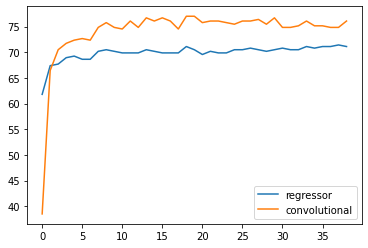

In [12]:
regressor.eval()
conv.eval()

print(f'REGRESSOR CONFUSION MATRIX:\n {confusion(regressor, test_loader, (0, 2))}')
print(f'CONVOLUTIONAL CONFUSION MATRIX:\n {confusion(conv, test_loader, (1, 2))}')

%matplotlib inline
x0, x1 = np.arange(len(accuracy_histories[0])), np.arange(len(accuracy_histories[1]))
plt.plot(x0, accuracy_histories[0], label='regressor')
plt.plot(x1, accuracy_histories[1], label='convolutional')
plt.legend()
plt.show()

tensor(1)


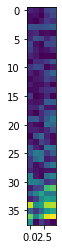

tensor(1)


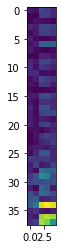

tensor(1)


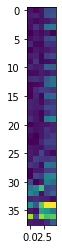

tensor(1)


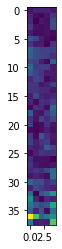

tensor(1)


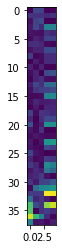

tensor(1)


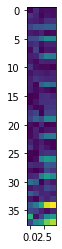

tensor(0)


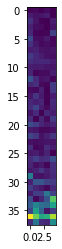

tensor(0)


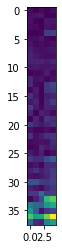

tensor(0)


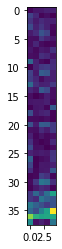

tensor(0)


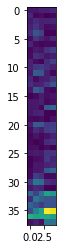

In [13]:
fig = plt.figure()
for i in range(10):
    print(test_data[i + 110][2])
    plt.imshow(np.rot90(test_data[i + 110][1][0]))
    plt.show()